# ML_EmployeeAttrition: Predicting Employee Attrition 

**Project Goal:**  
This project aims to **predict employee attrition** using numeric data.  
The dataset contains 1,200 records with 8 numeric columns suitable for **binary classification models**.  
The target (`Attrition`) is imbalanced (0 = stayed, 1 = left) and the data contains noise and outliers to simulate a realistic scenario.

**Column Descriptions:**

1. `EmployeeID` (int)  
   Unique identifier for each employee.

2. `Age` (float)  
   Employee's age. Includes some noise and outliers.

3. `YearsAtCompany` (float)  
   Number of years the employee has been with the company.

4. `JobSatisfaction` (float, 1–5)  
   Job satisfaction level. Values include some noise.

5. `MonthlyIncome` (float)  
   Monthly income in USD. Contains some extreme outliers.

6. `OverTime` (int: 0/1)  
   Whether the employee does overtime (1 = Yes, 0 = No).

7. `PerformanceScore` (float, 10–100)  
   Employee performance score, slightly correlated with JobSatisfaction and YearsAtCompany, includes noise.

8. `Attrition` (int: 0/1)  
   Target column: whether the employee left the company (1 = left, 0 = stayed).

> **Note:** The data is not perfectly random and clean; it contains noise, some NaNs, and outliers to mimic real-world scenarios.  
> This dataset is ideal for practicing **Data Cleaning, Feature Engineering, and Binary Classification modeling**.


In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , KFold , cross_val_score , GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier , VotingClassifier
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report

In [2]:
# Reading data from a CSV file and displaying all information
data = pd.read_csv('Employee Attrition Prediction.csv')
pd.set_option('display.width',1000)
print(data.head(5).round(2),'\n')        # Display the first 5 rows of the dataset
print(data.shape,'\n')                   # Display the number of rows and columns in the dataset
print(data.describe().round(2),'\n')     # Show a statistical summary of all numerical columns (count, mean, std, min, max, etc.)
print(data.groupby('Attrition').size())  # Group the dataset by 'efficient_home' and calculate the mean of each feature to see differences between efficient and inefficient homes

   EmployeeID   Age  YearsAtCompany  JobSatisfaction  MonthlyIncome  OverTime  PerformanceScore  Attrition
0       11178  27.0             0.0             4.83        2650.53         0             61.46          1
1       10865  32.0             1.0             4.64        1650.14         0             93.36          1
2       10101  32.0             1.0             4.01        3178.86         1             63.03          1
3       10439  35.0             3.0             1.50            NaN         1             29.02          0
4       10058  38.0             2.0             3.96        2370.56         0             65.86          0 

(1200, 8) 

       EmployeeID      Age  YearsAtCompany  JobSatisfaction  MonthlyIncome  OverTime  PerformanceScore  Attrition
count     1200.00  1156.00         1153.00          1173.00        1171.00   1200.00           1162.00    1200.00
mean     10599.50    35.39            2.73             3.20        2961.20      0.36             54.68       0.25
st

## Handling Missing Values and Outliers

Some columns in the dataset contain missing values (NaNs) and a few extreme outliers.  
Since the percentage of missing data is relatively small and the data contains potential outliers,  
we will use the **median** to fill in missing values instead of the mean.  

> **Why median?**  
> The median is less sensitive to extreme values, so it preserves the general distribution of the data  
> without being skewed by outliers.  
> This helps the model learn more robust patterns from the dataset.

In [3]:
num_cols = ['Age','YearsAtCompany','JobSatisfaction','MonthlyIncome','PerformanceScore']
for col in num_cols:
    data[col] = data[col].fillna(data[col].median())

## Updated Data Summary

We are running `data.describe()` again because the dataset has been **modified**:  
missing values have been handled and potential outliers may have been addressed.  

> **Note:** The summary statistics now reflect the cleaned dataset, so mean, median, min, max, and standard deviation might differ from the previous describe output.

In [4]:
print(data.describe().round(2),'\n')     # Show a statistical summary of all numerical columns (count, mean, std, min, max, etc.)

       EmployeeID      Age  YearsAtCompany  JobSatisfaction  MonthlyIncome  OverTime  PerformanceScore  Attrition
count     1200.00  1200.00         1200.00          1200.00        1200.00   1200.00           1200.00    1200.00
mean     10599.50    35.37            2.70             3.20        2959.23      0.36             54.68       0.25
std        346.55     8.09            2.65             0.95        1059.51      0.48             19.02       0.43
min      10000.00     9.00            0.00             1.00         800.00      0.00             10.00       0.00
25%      10299.75    30.00            1.00             2.54        2313.26      0.00             41.39       0.00
50%      10599.50    35.00            2.00             3.20        2879.90      0.00             54.66       0.00
75%      10899.25    40.00            4.00             3.87        3556.88      1.00             67.97       0.25
max      11199.00    80.00           20.00             5.00       12534.02      1.00    

## Data Visualization

In this section, we visualize the distribution and spread of numerical features  
to better understand their patterns, detect outliers, and identify possible skewness.

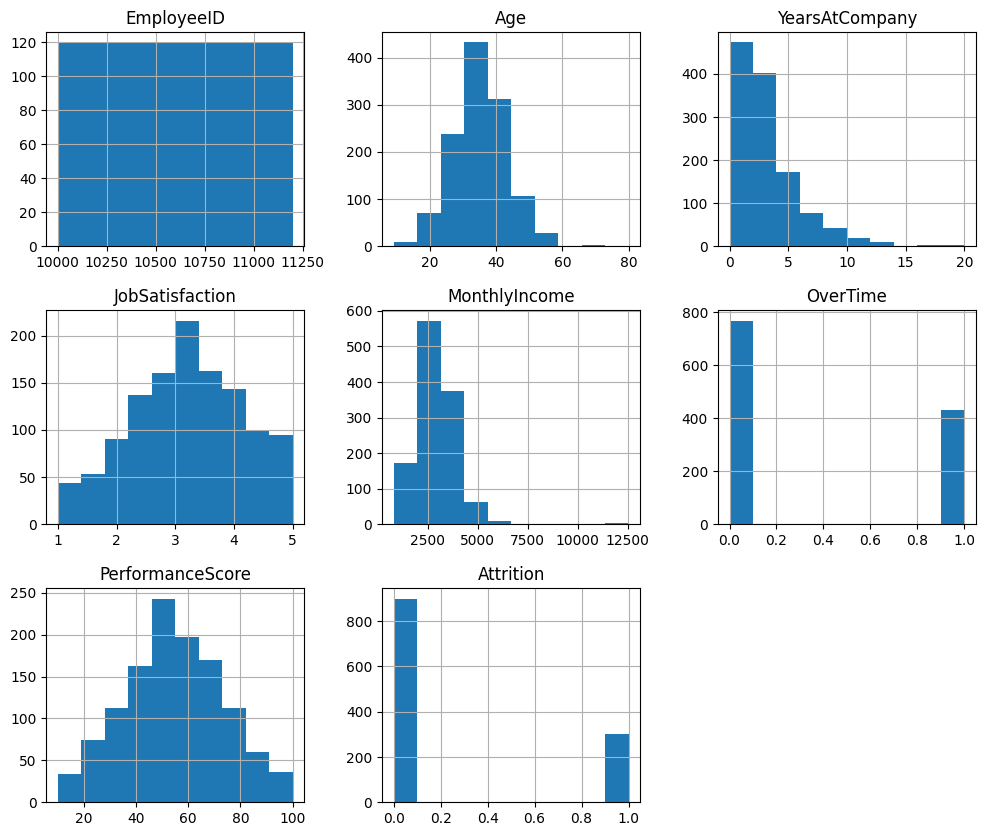

In [5]:
# Histogram
data.hist(figsize=(12,10))
plt.show()

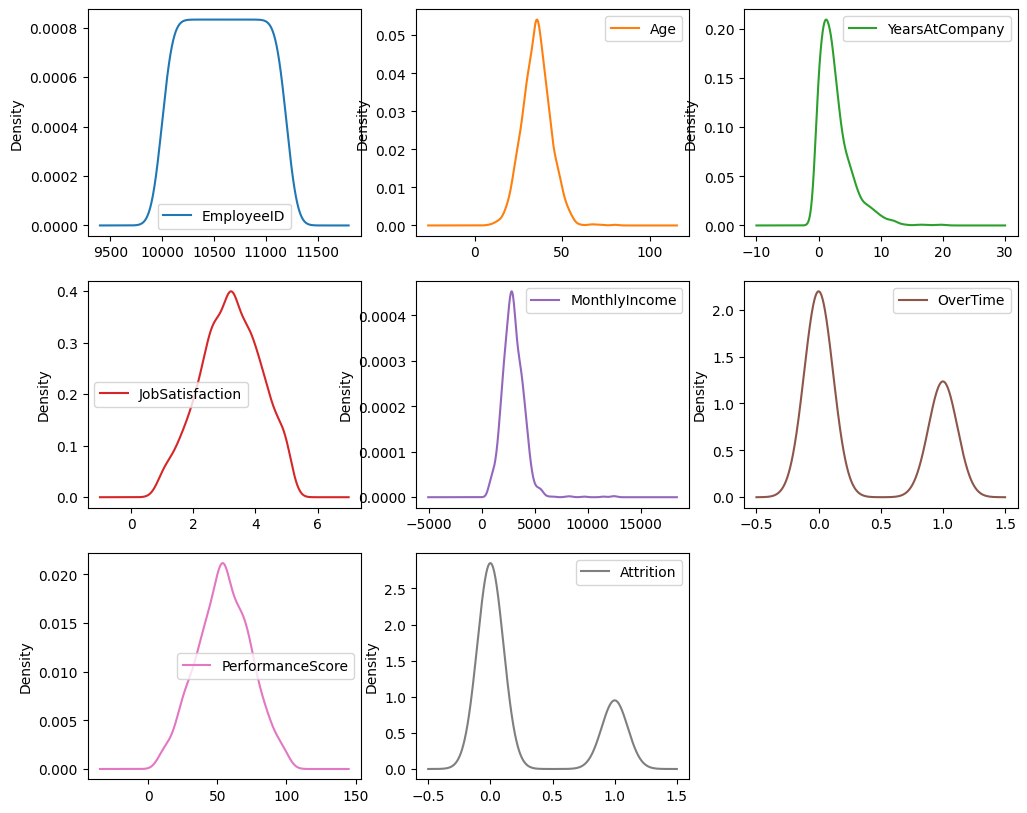

In [6]:
# Density
data.plot(kind='density',subplots=True,layout=(3,3),sharex=False,figsize=(12,10))
plt.show()

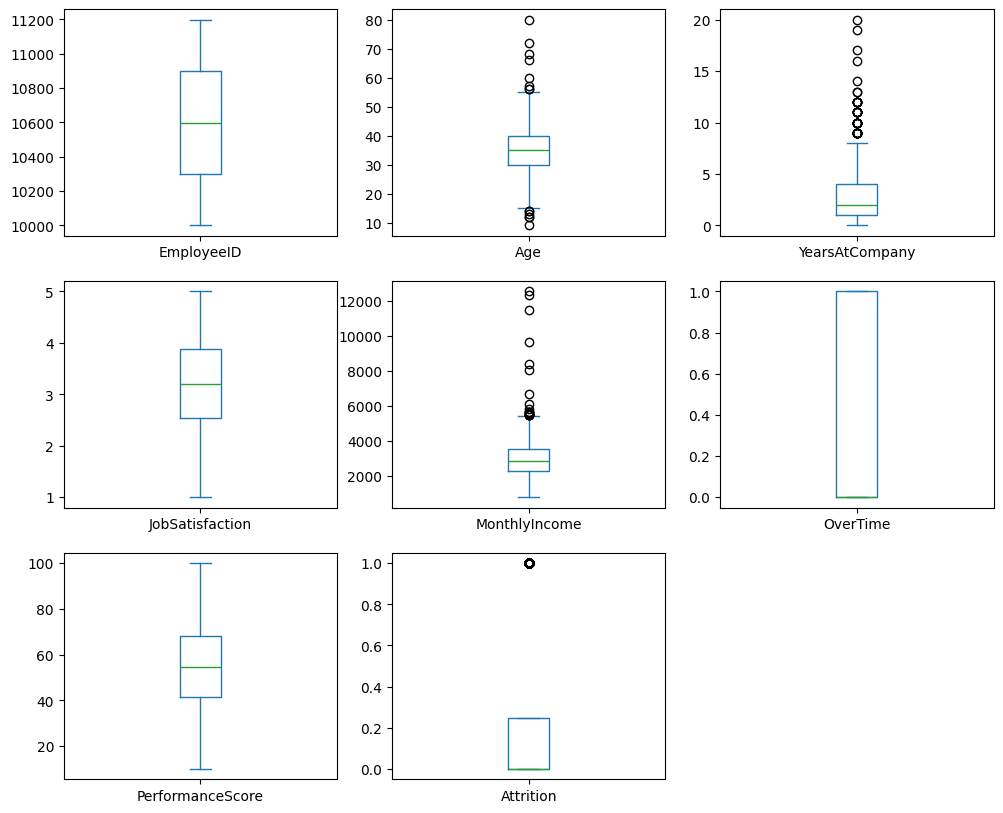

In [7]:
# BoxPlot
data.plot(kind='box',subplots=True,layout=(3,3),sharex=False,figsize=(12,10))
plt.show()

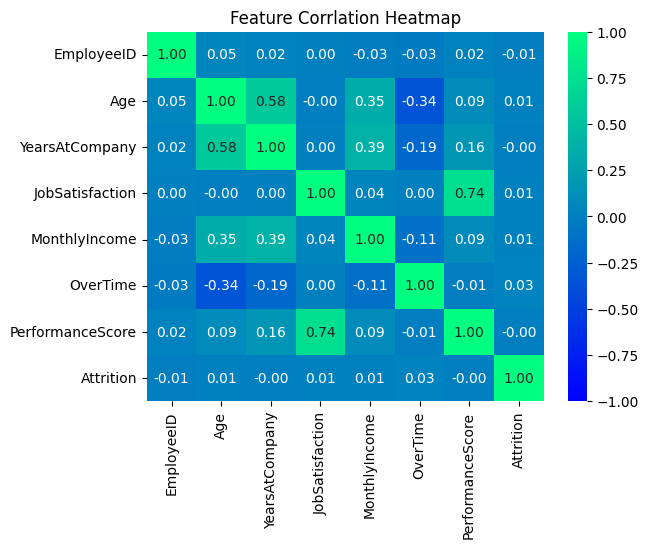

In [8]:
# Corrlation Matrix
sns.heatmap(data.corr(),vmin=-1,vmax=1,cmap='winter',annot=True,fmt='.2f')
plt.title('Feature Corrlation Heatmap')
plt.show()

## Train-Test Split

Before building and evaluating machine learning models,  
we need to divide the dataset into **training** and **testing** sets.

- The **training set** will be used to train the model and learn patterns from the data.  
- The **testing set** will be used to evaluate how well the model generalizes to unseen data.

We will use `train_test_split` from `sklearn.model_selection` to perform this step,  
typically using an **80/20** or **70/30** split ratio depending on dataset size.

In [9]:
X = data.drop(columns=['Attrition'])
Y = data['Attrition']
x_train , x_test , y_train , y_test = train_test_split(X,Y,test_size=0.3,random_state=7)

## Spot Check - Baseline Model Comparison

Before performing hyperparameter tuning or advanced optimization,  
we will run a **spot check** to quickly compare several baseline machine learning models.

This helps us identify which algorithms perform best on our dataset  
and narrow down the candidates for further fine-tuning.

The process includes:
1. Creating a list of models (`models = []`)
2. Iterating through them for training and evaluation using cross-validation
3. Comparing their accuracy scores to determine the most promising models

We'll use models such as:
- Logistic Regression  
- Decision Tree  
- LinearDiscriminantAnalysis
- K-Nearest Neighbors  
- Support Vector Machine  
- GaussianNB

In [10]:
models = []
models.append(('LR',LogisticRegression(max_iter=1000)))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('NB',GaussianNB()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('SVC',SVC()))

### Model Unpacking and Evaluation

Each model in our list will be **unpacked** using a loop  
(e.g., `for name, model in models:`) to fit and evaluate them individually.  
This allows us to efficiently compare their performance using cross-validation.

Name : LR , Mean : 73.21 % , STD : 6.53
Name : LDA , Mean : 73.10 % , STD : 6.57
Name : KNN , Mean : 66.55 % , STD : 5.75
Name : NB , Mean : 72.26 % , STD : 6.69
Name : CART , Mean : 57.50 % , STD : 5.08
Name : SVC , Mean : 73.21 % , STD : 6.53


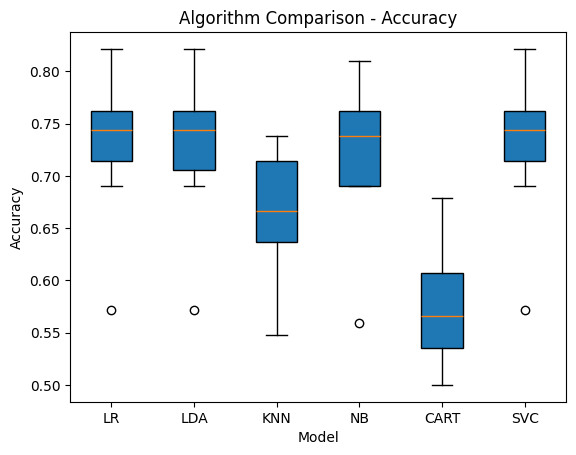

In [11]:
result = []
names = []
for name , model in models:
    kfold = KFold(n_splits=10,shuffle=True,random_state=7)
    cv_result = cross_val_score(model,x_train,y_train,cv=kfold,scoring='accuracy')
    result.append(cv_result)
    names.append(name)
    print(f'Name : {name} , Mean : {cv_result.mean()*100:.2f} % , STD : {cv_result.std()*100:.2f}')
plt.figure()
plt.boxplot(result,tick_labels=names,patch_artist=True)
plt.title('Algorithm Comparison - Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

## Spot Check with Pipelines and StandardScaler

In this step, we repeat the baseline model comparison using **pipelines**.  
We include **StandardScaler** in each pipeline to scale numeric features,  
ensuring models like KNN and SVC perform optimally.  

Each pipeline contains:
1. **StandardScaler** for feature scaling  
2. The corresponding classifier (LR, LDA, KNN, NB, CART, SVC)  

We will perform cross-validation to evaluate model performance on the scaled data.

Name : LR , Mean : 73.21 % , STD : 6.53
Name : LDA , Mean : 73.10 % , STD : 6.57
Name : KNN , Mean : 66.90 % , STD : 8.38
Name : NB , Mean : 72.26 % , STD : 6.69
Name : CART , Mean : 57.14 % , STD : 3.57
Name : SVC , Mean : 73.21 % , STD : 6.53


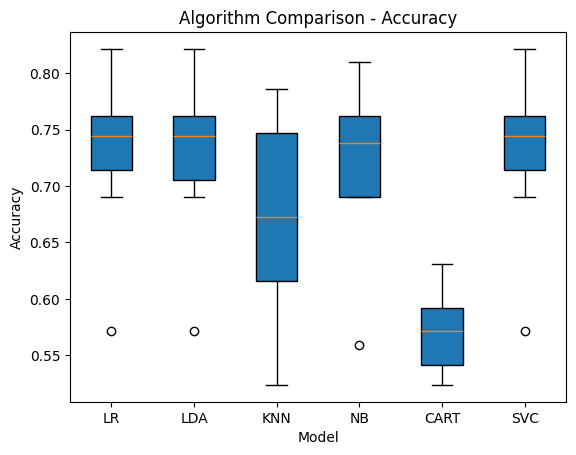

In [12]:
scaled_result = []
for name , model in models:
    piplelines = Pipeline([
        ('Scaled',StandardScaler()),
        ('Classifier',model)
    ])
    kfold = KFold(n_splits=10,shuffle=True,random_state=7)
    cv_result = cross_val_score(piplelines,x_train,y_train,cv=kfold,scoring='accuracy')
    scaled_result.append(cv_result)
    print(f'Name : {name} , Mean : {cv_result.mean()*100:.2f} % , STD : {cv_result.std()*100:.2f}')
plt.figure()
plt.boxplot(scaled_result,tick_labels=names,patch_artist=True)
plt.title('Algorithm Comparison - Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

## Ensemble Methods Spot Check

In this section, we will evaluate several ensemble methods on our dataset.  

The goal is to compare their performance using cross-validation and identify the most promising model for further tuning.

We will include:
- **Random Forest (Bagging)**: Reduces variance using multiple decision trees.  
- **Voting Classifier**: Combines different base models (LR, SVC, NB) to improve overall accuracy.  
- **AdaBoost (Boosting)**: Sequentially focuses on samples that previous models misclassified.  
- **Gradient Boosting**: Gradient-based boosting for high predictive performance.  

All models will use a **Pipeline with StandardScaler** to ensure proper feature scaling.

Name : RF , Mean : 70.60 % , STD : 6.71
Name : VT , Mean : 73.10 % , STD : 6.57
Name : AB , Mean : 73.10 % , STD : 6.37
Name : SGB , Mean : 69.76 % , STD : 6.80


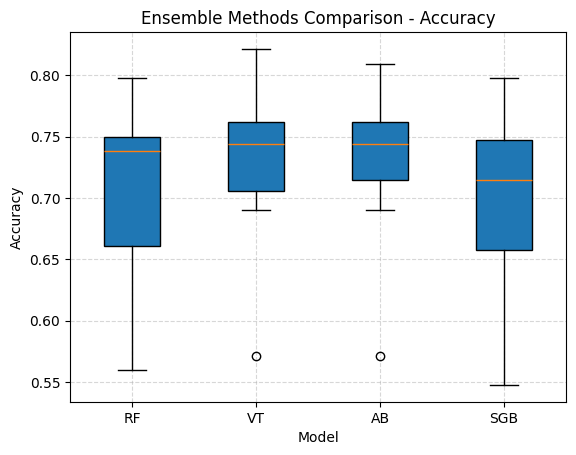

In [13]:
# Base models for Voting
base_models = [
    ('LR',LogisticRegression(max_iter=1000)),
    ('SVC',SVC(probability=True)),
    ('NB',GaussianNB())
]
# Ensemble models
ensemble_models = [
    ('RF',RandomForestClassifier(n_estimators=100,random_state=7)),
    ('VT',VotingClassifier(estimators=base_models,voting='soft')),
    ('AB',AdaBoostClassifier(n_estimators=50,random_state=7)),
    ('SGB',GradientBoostingClassifier(n_estimators=100,random_state=7))
]
ensemble_result = []
ensemble_name = []
for name , model in ensemble_models:
    pipeline = Pipeline([
        ('Scaled',StandardScaler()),
        ('Classifier',model)
    ])
    kfold = KFold(n_splits=10,shuffle=True,random_state=7)
    cv_result = cross_val_score(pipeline,x_train,y_train,cv=kfold,scoring='accuracy')
    ensemble_result.append(cv_result)
    ensemble_name.append(name)
    print(f'Name : {name} , Mean : {cv_result.mean()*100:.2f} % , STD : {cv_result.std()*100:.2f}')
plt.figure()
plt.boxplot(ensemble_result,tick_labels=ensemble_name,patch_artist=True)
plt.title('Ensemble Methods Comparison - Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Focus: Tuning Voting and AdaBoost

We will focus our effort on two ensemble approaches:
- **VotingClassifier** (combine LR, SVC, NB) — try hard vs soft and different weightings.
- **AdaBoostClassifier** (with decision stumps / small trees) — tune `n_estimators` and `learning_rate`.

Procedure:
1. Build Pipelines that include `StandardScaler` and the ensemble classifier.
2. Use `GridSearchCV` / cross-validation to find good hyperparameters.
3. Compare CV results and pick the best model(s) for final evaluation.

In [14]:
# Settings
random_state = 7
kfold = KFold(n_splits=10,shuffle=True,random_state=random_state)
scoring = 'accuracy'
# 1. AdaBoost : GridSerche over n_estimators and learning_rate
ada_pipe = Pipeline([
    ('Scaled',StandardScaler()),
    ('Classifier',AdaBoostClassifier(random_state=random_state))
])
ada_param_grid = {
    'Classifier__n_estimators' : [50,100,200],
    'Classifier__learning_rate' : [0.01,0.1,0.5,1.0],
    # note: to tune base_estimator parameters, we set classifier__base_estimator__max_depth
    'Classifier__estimator' : [DecisionTreeClassifier(max_depth=1),
                                    DecisionTreeClassifier(max_depth=2)]
}
ada_grid = GridSearchCV(
    estimator=ada_pipe,
    param_grid=ada_param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    verbose=1
)
ada_grid.fit(x_train,y_train)
print(f'AdaBoost - Best CV accuracy : {ada_grid.best_score_*100:.2f}')
print(f'AdaBoost - Best params : {ada_grid.best_params_}')

Fitting 10 folds for each of 24 candidates, totalling 240 fits
AdaBoost - Best CV accuracy : 73.33
AdaBoost - Best params : {'Classifier__estimator': DecisionTreeClassifier(max_depth=2), 'Classifier__learning_rate': 0.01, 'Classifier__n_estimators': 100}


In [15]:
# 2. VotingClassifier: try hard vs soft and a few weight combos
# note: SVC needs probability=True for soft voting
estimators = [
    ('SVC',SVC(probability=True,random_state=random_state)),
    ('LR',LogisticRegression(max_iter=1000,random_state=random_state)),
    ('NB',GaussianNB())
]
# Build pipeline with Voting as final estimator
voting_pipe = Pipeline([
    ('Scaled',StandardScaler()),
    ('Classifier',VotingClassifier(estimators=estimators))
])
voting_param_grid = {
    'Classifier__voting' : ['hard','soft'],
    'Classifier__weights' : [None,(1,1,2),(1,2,1),(2,1,1)]
}
voting_grid = GridSearchCV(
    estimator=voting_pipe,
    param_grid=voting_param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    verbose=1
)
voting_grid.fit(x_train,y_train)
print(f'Voting - Best CV accuracy : {voting_grid.best_score_*100:.2f}')
print(f'Voting - Best params : {voting_grid.best_params_}')

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Voting - Best CV accuracy : 73.21
Voting - Best params : {'Classifier__voting': 'hard', 'Classifier__weights': None}


# 🚀 Final Prediction with Logistic Regression

---

## 🏁 Overview

We've come a long way! 🎉  
From creating synthetic data, cleaning it, exploring distributions, testing multiple models, and even trying ensemble methods, we've seen how different algorithms perform.  

Now, we are taking a **strategic step back** to focus on a **single, strong model** for final prediction.  
- **Model of choice:** Logistic Regression (LR)  
- **Reason:** High accuracy, stability, interpretability, and speed.  
- **Pipeline:** StandardScaler + Logistic Regression  
  - Ensures numerical features are scaled correctly  
  - Makes the model more reliable across different folds  

---

## 🎯 Goals

1. Train a **robust LR pipeline** on the training set  
2. Evaluate using **cross-validation** to ensure stability  
3. Predict on the test set  
4. Assess performance with:
   - Accuracy
   - Classification Report
   - Confusion Matrix

---

## 💡 Reminder

Even though we've tried ensembles like Voting and AdaBoost, the performance gain was minimal.  
Sometimes, simplicity is the **ultimate sophistication**. 🧠✨  

By focusing on a **single, interpretable model**, we can make confident predictions and fully understand the behavior of our system.  

---

## ⚡ Let's get back to the **first floor** — but this time with wisdom and experience! 🏗️💪

In [16]:
# Build Pipeline
lr_pipe = Pipeline([
    ('Scaled',StandardScaler()),
    ('LR',LogisticRegression(max_iter=1000,random_state=7,class_weight='balanced'))
])
kfold = KFold(n_splits=10,random_state=7,shuffle=True)
cv_result = cross_val_score(lr_pipe,x_train,y_train,cv=kfold,scoring='accuracy')
print(f'LR = Accuracy : {cv_result.mean()*100:.2f} % , STD : {cv_result.std()*100:.2f}')
# Train on full training set
lr_pipe.fit(x_train,y_train)
# Prediction on test set
prediction = lr_pipe.predict(x_test)
# Evaluation
print(f'\nTest Accuracy : {accuracy_score(y_test,prediction)*100:.2f}')
print('\nClassification Report :\n',classification_report(y_test,prediction,zero_division=0))
print('Confusion Matrix :\n',confusion_matrix(y_test,prediction))

LR = Accuracy : 49.64 % , STD : 6.16

Test Accuracy : 46.94

Classification Report :
               precision    recall  f1-score   support

           0       0.78      0.46      0.58       285
           1       0.19      0.49      0.28        75

    accuracy                           0.47       360
   macro avg       0.49      0.48      0.43       360
weighted avg       0.66      0.47      0.52       360

Confusion Matrix :
 [[132 153]
 [ 38  37]]


## 🧠 Final Thoughts & Model Behavior Analysis

After extensive experiments (baseline models, pipelines, and ensembles), we selected **Logistic Regression** as the final baseline due to its stability, interpretability, and competitive cross-validation performance.

### Why we used `class_weight='balanced'`
Our dataset is **imbalanced** (the majority class dominates). When trained without addressing the imbalance, the model learned a trivial strategy: always predict the majority class. To force the model to pay attention to the minority class, we used:

```python
LogisticRegression(..., class_weight='balanced')
```

This makes the model assign larger importance (weight) to minority-class samples during training, helping it learn to detect those cases.

---

### What happened to Accuracy — why it dropped?
Before balancing, the model often predicted only the majority class. This produced a deceptively high **accuracy** (e.g., ~79%) because most samples belonged to that class. After enabling `class_weight='balanced'`, the model started predicting the minority class as well. As a consequence:
- **Accuracy decreased** (e.g., from ~79% → ~47%)
- **Recall for class `1` improved** (from 0.00 → ~0.49)

This drop is expected and even desirable when the goal is to detect rare events or minority classes. It means the model is no longer biased toward the majority class and is learning to make harder, fairer decisions.

---

### Why did the model make many mistakes originally (i.e., ignore class `1`)?
- The model minimized global error, so it favored predicting the majority class.
- Because class `1` had fewer samples, it barely affected the total loss.
- Therefore, the model simply ignored it — achieving high accuracy but terrible recall for class `1`.

After balancing, the model now "cares" about class `1`, making more attempts to classify it — even if that introduces more errors overall.

---

### Handling undefined metrics (`zero_division`)
When the model predicts zero samples for a class, some metrics (like precision) become undefined. To prevent this, we used:

```python
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, zero_division=0))
```

`zero_division=0` replaces undefined metric values with 0, avoiding warnings and making the output readable.

---

### Practical outcome (what changed)
- **Before balancing:** High accuracy (~79%) but model ignored class `1` entirely (`recall=0.00`).
- **After balancing:** Lower accuracy (~47%) but the model successfully detects some minority cases (`recall≈0.49`).
- This trade-off improves fairness and makes the model more realistic in imbalanced situations.

---

### Takeaway
- High accuracy alone can be misleading on imbalanced datasets.
- It’s better to have moderate accuracy with balanced recall across classes than high accuracy with zero detection of the minority class.
- The drop in accuracy reflects progress — the model stopped “playing safe” and started learning to identify underrepresented cases.

---